# Q3 - 三個粉絲專頁 Posts 的 Comments 數量箱型圖

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
import seaborn as sb
sb.set_style("whitegrid")
import pyes
es_address='127.0.0.1:9200'
conn = pyes.es.ES(es_address)

## 然後我發現一件事

post 資料集中 Query 的 field = "id" 與 comment 資料集中 Query 的 field = "fid_pid" 是同一個東西

**(fid_pid 指的是 fanpage id + post id)** 

所以，我可以從 post 資料集中的 comment_count 欄位直接得知 comments 數量

也可從 comment 資料集中的每個 fid_pid 計算 comments 數量。

## 但是

傻子都知道要用 post 資料集中的 comment_count 欄位比較快，而且 post 資料集應該比 comments 資料集還要新

因為幾乎每則 post 的 comments 數量，都是 post 資料集裡記錄的比較多。

## 再但是

如果上面的推論其實都是錯的，那真正的傻子就是我ㄌ

In [34]:
CommentsCount = dict()

def Calculation(fid):
    q = pyes.query.BoolQuery()
    
    fq = pyes.query.TermQuery(field="fid", value=fid)
    q.add_must(fq)
    
    PostResult = conn.search(query=q , indices='facebook_nested' , doc_types='post') 
    
    for x in range(len(PostResult)):
        pid = str(PostResult[x]['id'])

        p = pyes.query.BoolQuery()
        
        cq = pyes.query.TermQuery(field="id", value=pid)
        p.add_must(cq)
    
        CommentResult = conn.search(query=p , indices='facebook_nested' , doc_types='post') 
        
        if fid in CommentsCount:
            CommentsCount[fid].append(CommentResult[0]['comment_count'])
        else:
            CommentsCount[fid] = [CommentResult[0]['comment_count']]
    
Calculation(156435698616)
Calculation(134004310003557)
Calculation(170290829685289)

# 計算完成

接下來把資料塞進 DataFrame，然後把圖畫出來就對了

天哪！這樣對嗎？

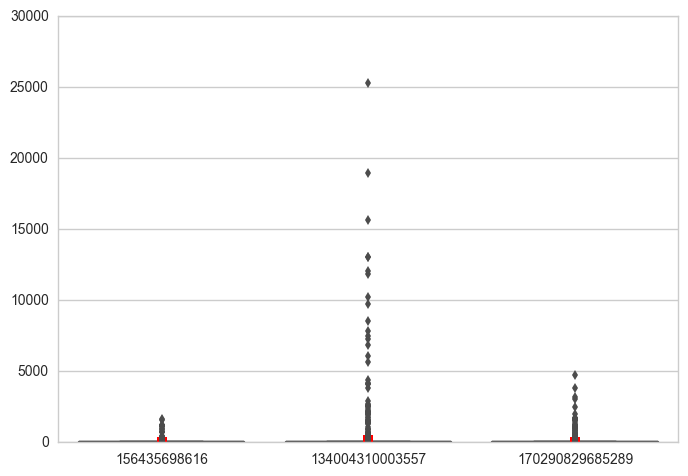

In [49]:
df = pd.DataFrame(dict([(k,Series(v)) for k,v in CommentsCount.iteritems()])) # 將沒有資料的欄位填上 NaN
# print(df.to_string())
ax = sb.boxplot(df, vert=True, showmeans=True)

# 調整 y 軸範圍

這樣看起來好多了

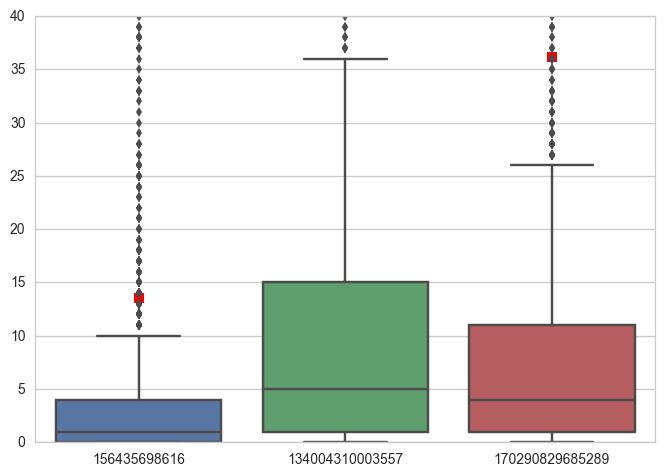

In [57]:
plt.ylim(0, 40)
ax = sb.boxplot(df, vert=True, showmeans=True)